<a href="https://colab.research.google.com/github/ajainuary/face-classification/blob/main/Face_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Classification

In [ ]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

pandas 0.25.0+0.gd1accd0.dirty has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
jupyterlab-server 1.0.0 has requirement jsonschema>=3.0.1, but you'll have jsonschema 2.6.0 which is incompatible.
ipywidgets 7.0.0 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
import seaborn as sn

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, Isomap
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

plt.ion()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/home/ajainuary/.conda/envs/smai/lib/python3.6/site-packages/daal4py/sklearn/monkeypatch/dispatcher.py:90: UserWarning: daal4py (2019, 4) has only been tested with scikit-learn 0.21.1, found version: 0.21.3
  warnings.warn(warn_msg.format(daal4py_version=daal4py_version, sklearn_version=sklearn_version))


# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [ ]:
opt = {
    'image_size': 64,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [ ]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [ ]:
# Loading the dataset
# eg.
X_all = [[], [], []]
y_all = [[], [], []]
N_all = [0, 0, 0]
H_all = [0, 0, 0]
W_all = [0, 0, 0]
C_all = [0, 0, 0]
X_all[0],y_all[0] = load_data('./dataset/IIIT-CFW/')
C_all[0] = 1 if opt['is_grayscale'] else X_all[0].shape[3]
X_all[1],y_all[1] = load_data('./dataset/IMFDB/')
C_all[1] = 1 if opt['is_grayscale'] else X_all[1].shape[3]
X_all[2],y_all[2] = load_data('./dataset/Yale_face_database/')
C_all[2] = 1 if opt['is_grayscale'] else X_all[2].shape[3]
for i in range(3):
    N_all[i],H_all[i],W_all[i] = X_all[i].shape[0:3]
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (672, 64, 64, 3)
Dataset shape: (400, 64, 64, 3)
Dataset shape: (165, 64, 64, 3)
Dataset shape: (400, 64, 64, 3)


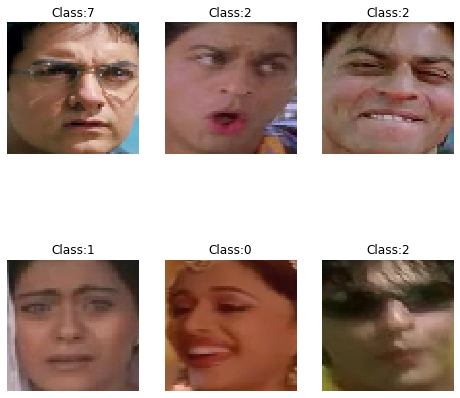

In [ ]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [ ]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [ ]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [ ]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [ ]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [ ]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [ ]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [ ]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

The significant features / eigenvectors which on projecting the data span the maximum variance. Therefore they are able to capture maximum information from the dataset.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? 

Ideally, since there are similarities in the data we only need few eigenvectors to reconstruct the data satisfactorily. As shown by the eigenspectrum (plot of the eigenvalues) the last eigenvalues contribute little information. For the IIIT-CFW Dataset we need upto 100 eigenvectors but for IMFDB and Yale Face Dataset we need upto 50 eigenvectors.

In [ ]:
# Compute your features 
# eg.
X_3D = get_pca(X,3)

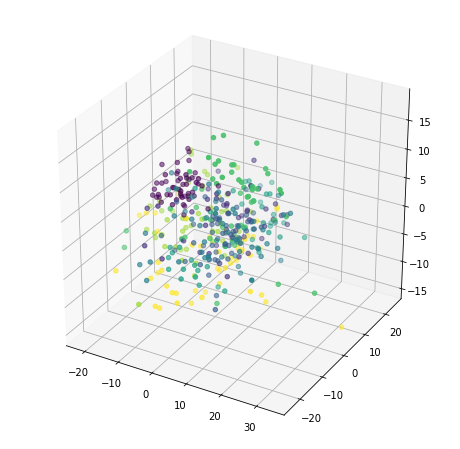

In [ ]:
# Create a scatter plot
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

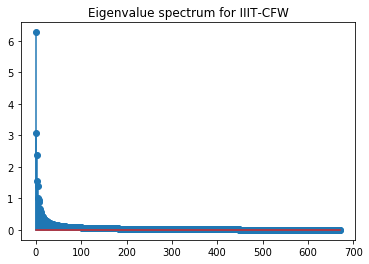

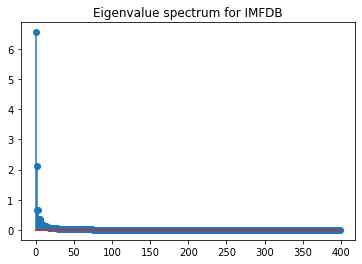

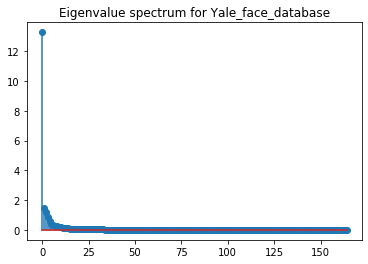

In [ ]:
# Plot the eigen value spectrum 
dirpaths = ['IIIT-CFW', 'IMFDB', 'Yale_face_database']
for i in range(3):
    w = np.linalg.eigvalsh(np.cov(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i]))))
    w[::-1].sort()
    plt.stem(w)
    plt.title('Eigenvalue spectrum for ' + dirpaths[i])
    plt.show()


1(c). Reconstruct  the  image  back for each case


In [ ]:
def reconstruct_images(X, k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    pass
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    reconstruct_X = pca.inverse_transform(X_k)
    
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


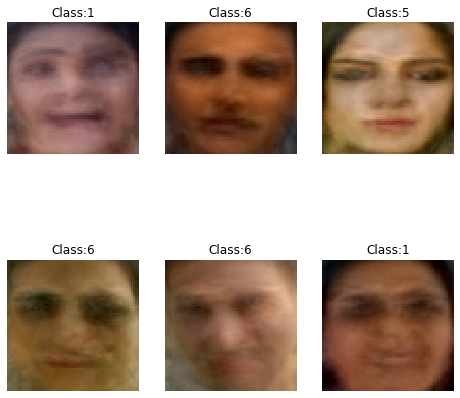

0.06219676574195999
We need 230 eigenvectors for IIIT-CFW to have reconstruction error < 10%
We need 10 eigenvectors for IMFDB to have reconstruction error < 10%
We need 21 eigenvectors for Yale Face Dataset to have reconstruction error < 10%


In [ ]:
# Display results 
X_reconstructed = reconstruct_images(X, 50)
# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstructed[ind,...].reshape((ind.shape[0], W, H, C)),y[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstructed)**2)))
err = 1
i = 1
while err > 0.1:
    X_reconstructed = reconstruct_images(X_all[0].reshape((N_all[0],H_all[0]*W_all[0]*C_all[0])), i)
    err = np.sqrt(np.mean((X_all[0].reshape((N_all[0],H_all[0]*W_all[0]*C_all[0])) - X_reconstructed)**2))
    i = i+1
print("We need", i, "eigenvectors for IIIT-CFW to have reconstruction error < 10%")
err = 1
i = 1
while err > 0.1:
    X_reconstructed = reconstruct_images(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])), i)
    err = np.sqrt(np.mean((X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])) - X_reconstructed)**2))
    i = i+1
print("We need", i, "eigenvectors for IMFDB to have reconstruction error < 10%")
err = 1
i = 1
while err > 0.1:
    X_reconstructed = reconstruct_images(X_all[2].reshape((N_all[2],H_all[2]*W_all[2]*C_all[2])), i)
    err = np.sqrt(np.mean((X_all[2].reshape((N_all[2],H_all[2]*W_all[2]*C_all[2])) - X_reconstructed)**2))
    i = i+1
print("We need", i, "eigenvectors for Yale Face Dataset to have reconstruction error < 10%")


The images from the cartoon dataset are difficult to represent
        compactly with few eigen vectors due to lack of similarity and
        changes in pose. Since the variations lie along many axes, it is
        difficult to capture the same using only a few eigenvectors. In
        the IIIT-CFW Dataset Manmohan Singh has a high reconstruction
        error since he has a turban which others do not have, from the
        IFMDB Database Amitabh Bachan is difficult to capture because he
        has a beard whereas other actors do not and in the Yale Dataset
        Class 13 has high reconstruction error.

In [ ]:
# code goes here
max_err = -1
max_idx = -1
for i in range(8):
    idx = np.flatnonzero(y_all[0] == i)
    X_reconstructed = reconstruct_images(X_all[0].reshape((N_all[0],H_all[0]*W_all[0]*C_all[0])), 10)
    err = np.sqrt(np.mean((X_all[0].reshape((N_all[0],H_all[0]*W_all[0]*C_all[0]))[idx] - X_reconstructed[idx])**2))
    if err > max_err:
        max_idx = i
        max_err = err
print('Class with max reconstruction error in IIIT-CFW: ', max_idx, 'with error', max_err)
max_err = -1
max_idx = -1
for i in range(8):
    idx = np.flatnonzero(y_all[1] == i)
    X_reconstructed = reconstruct_images(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])), 10)
    err = np.sqrt(np.mean((X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1]))[idx] - X_reconstructed[idx])**2))
    if err > max_err:
        max_idx = i
        max_err = err
print('Class with max reconstruction error in IMFDB: ', max_idx, 'with error', max_err)
max_err = -1
max_idx = -1
for i in range(15):
    idx = np.flatnonzero(y_all[2] == i)
    X_reconstructed = reconstruct_images(X_all[2].reshape((N_all[2],H_all[2]*W_all[2]*C_all[2])), 10)
    err = np.sqrt(np.mean((X_all[2].reshape((N_all[2],H_all[2]*W_all[2]*C_all[2]))[idx] - X_reconstructed[idx])**2))
    if err > max_err:
        max_idx = i
        max_err = err
print('Class with max reconstruction error in Yale Face Database: ', max_idx, 'with error', max_err)

Class with max reconstruction error in IIIT-CFW:  6 with error 0.22541487870487478
Class with max reconstruction error in IMFDB:  4 with error 0.10866976857609321
Class with max reconstruction error in Yale Face Database:  7 with error 0.14984965458298383



1.  *IIIT-CFW* - For this dataset containing many variations,
    Kernel LDA produces the best features for classification.
    Along with this, SVM offered the best classification
    accuracy since one the data is linearly separable (after
    using Kernel LDA), SVM works quite well. The VGG Features
    are not very helpful in case of cartoons and perform poorly
    here. PCA is also not able to properly capture the
    variations and performs poorly. However, the best option is
    to chose all the features and classify them using a MLP, and
    let the network learn which features are important and which
    are not.

2.  *IMFDB* - IMFDB was extracted from Indian Movies, since
    characters in movies show different variations in
    expressions and pose, there would be higher variation in
    illumination, resolution, blur among the samples from the
    same person. Due to this variation we would need to consult
    a lot of features before classifying a sample, thus best
    option would be to choose all features and then use a SVM to
    classify the data. Due to the variations, PCA does not work
    well here.

3.  *Yale Face Database* - This dataset is the simplest one with
    the least variations among the same person but considerable
    variation between different people. In this case we have
    many feature-classifier combos offering good performance for
    e.g. LDA + SVM is a simple classifier but offers good
    performance here.


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [ ]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self, method):
        if method == 'SVM':
            self.clf = SVC(gamma='scale')
        elif method == 'MLP':
            self.clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 50), random_state=42, max_iter=1e4)
        elif method == 'DT':
            self.clf = tree.DecisionTreeClassifier()
        elif method == 'LR':
            self.clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.clf.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        return confusion_matrix(y, pred)
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_predict = self.clf.predict(X_validate)
        # Create a confusion matrix
        confusion_mtx = self.confusion_matrix(y_predict, y_validate)
        # Calculate Validation accuracy 
        correct = np.sum(y_predict == y_validate)
        accuracy = correct / y_validate.shape[0]
        # Calculate precision and recall 
        precision = precision_score(y_validate, y_predict, average='macro')
        recall = recall_score(y_validate, y_predict, average='macro')
        # Calculate F1-score
        f1 = f1_score(y_validate, y_predict, average='macro')
        return confusion_mtx, accuracy, precision, recall, f1

In [ ]:
# Create a train and validation split to train your classifier

In [ ]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

def score(x, X_train, X_validate, y_train, y_validate):
    clf = Classifier(x)
    clf.train(X_train, y_train)
    return clf.validate(X_validate, y_validate)
dirpaths = ['IIIT-CFW', 'IMFDB', 'Yale_face_database']
d = []
cf_mtx = []
for i in range(3):
    d.append({'Method': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []})
    cf_mtx.append([])
    for x in ['SVM', 'MLP', 'DT', 'LR']:
        X_train, X_validate, y_train, y_validate = train_test_split(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Raw Image Data + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(get_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('PCA + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(get_kernel_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Kernel PCA + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(get_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('LDA + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Kernel LDA + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(get_vgg_features('./dataset/'+ dirpaths[i] + '/'), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('VGG Features + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(get_resnet_features('./dataset/'+ dirpaths[i] + '/'), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Resnet Features + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(np.hstack((get_resnet_features('./dataset/'+ dirpaths[i] + '/'), get_vgg_features('./dataset/'+ dirpaths[i] + '/'))), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Resnet + VGG Features + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(np.hstack((get_kernel_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20))), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('KPCA + KLDA + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
        X_train, X_validate, y_train, y_validate = train_test_split(np.hstack((get_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), get_kernel_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), get_resnet_features('./dataset/'+ dirpaths[i] + '/'), get_vgg_features('./dataset/'+ dirpaths[i] + '/'))), y_all[i], test_size=0.25, random_state=42)
        confusion_mtx, accuracy, precision, recall, f1 = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('All Features + ' + x)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        d[i]['Recall'].append(recall)
        d[i]['F1 Score'].append(f1)
        cf_mtx[i].append(confusion_mtx)
    print(dirpaths[i])
    df = pd.DataFrame(d[i])
    print(df)
# Print the table. (You can use Pandas)


IIIT-CFW
                         Method  Accuracy  Precision    Recall  F1 Score
0          Raw Image Data + SVM  0.517857   0.535629  0.503176  0.504575
1                     PCA + SVM  0.547619   0.587471  0.546260  0.549748
2              Kernel PCA + SVM  0.541667   0.578594  0.543806  0.546358
3                     LDA + SVM  0.910714   0.911505  0.912389  0.909830
4              Kernel LDA + SVM  0.964286   0.970833  0.965852  0.967000
5            VGG Features + SVM  0.690476   0.698431  0.636413  0.646773
6         Resnet Features + SVM  0.982143   0.984707  0.978896  0.981410
7   Resnet + VGG Features + SVM  0.982143   0.983562  0.971320  0.976185
8             KPCA + KLDA + SVM  0.964286   0.970833  0.965852  0.967000
9            All Features + SVM  0.988095   0.986478  0.988366  0.987060
10         Raw Image Data + MLP  0.464286   0.445854  0.459698  0.444572
11                    PCA + MLP  0.494048   0.495081  0.492101  0.487516
12             Kernel PCA + MLP  0.488095 

For IIIT-CFW best model is All Features + MLP


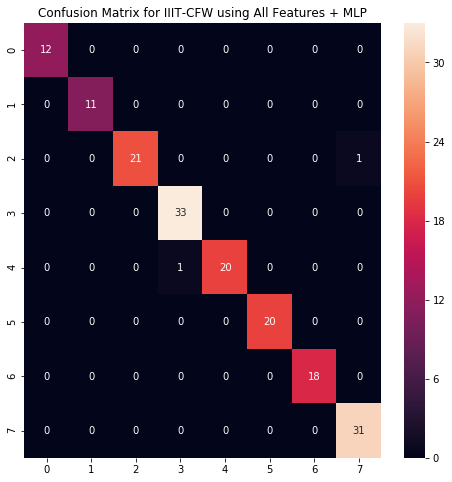

For IMFDB best model is All Features + SVM


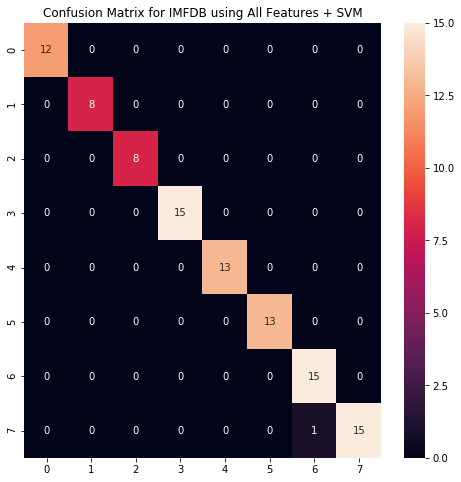

For Yale_face_database best model is LDA + SVM


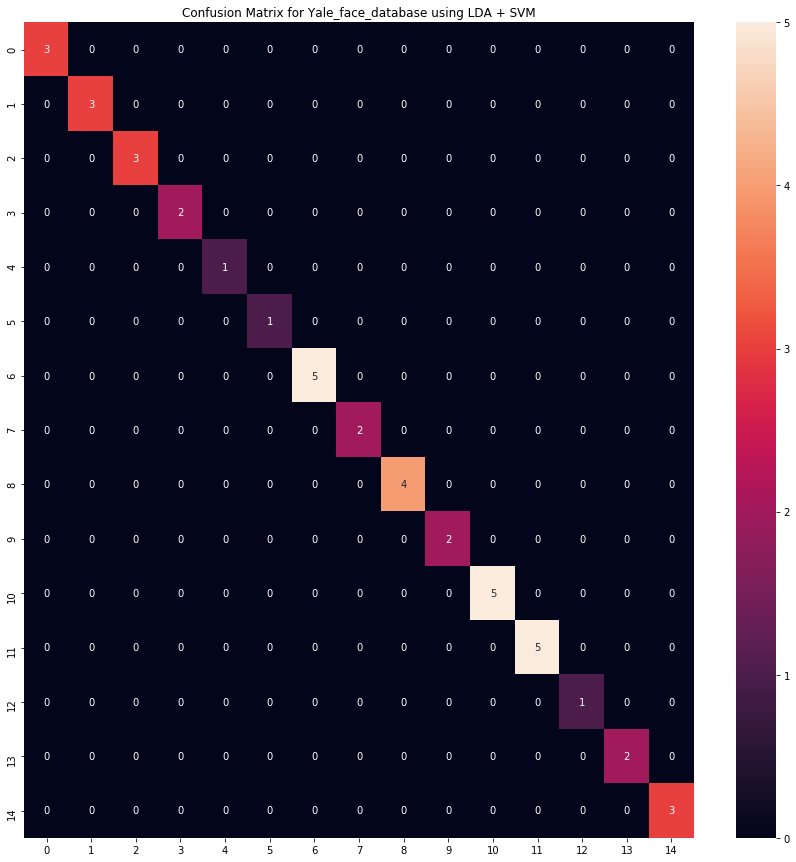

In [ ]:
# For each dataset print the confusion matrix for the best model 
for i in range(3):
    best_idx = np.argmax(d[i]['F1 Score'])
    print('For ' + dirpaths[i] + ' best model is ' + d[i]['Method'][best_idx])
    plt.figure(figsize = cf_mtx[i][best_idx].shape)
    ax = sn.heatmap(cf_mtx[i][best_idx], annot=True)
    ax.set_ylim(cf_mtx[i][best_idx].shape[0], 0)
    plt.title('Confusion Matrix for ' + dirpaths[i] + ' using ' + d[i]['Method'][best_idx])
    plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

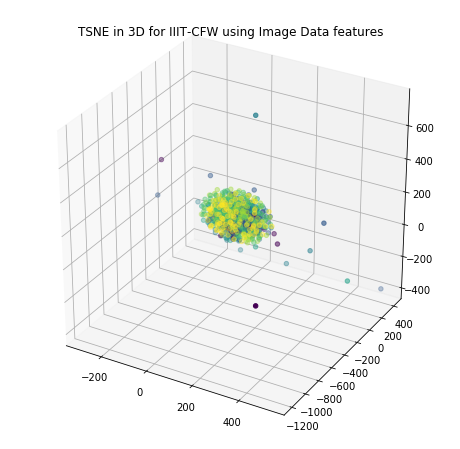

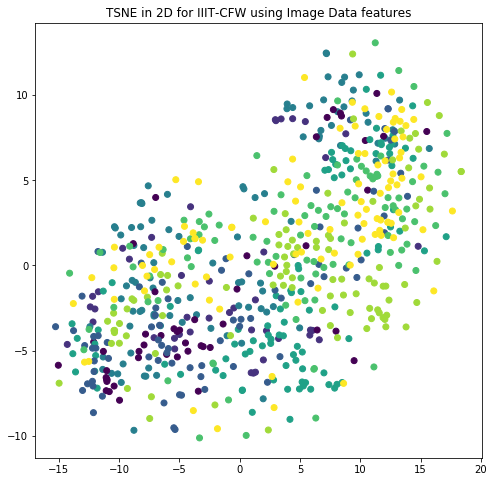

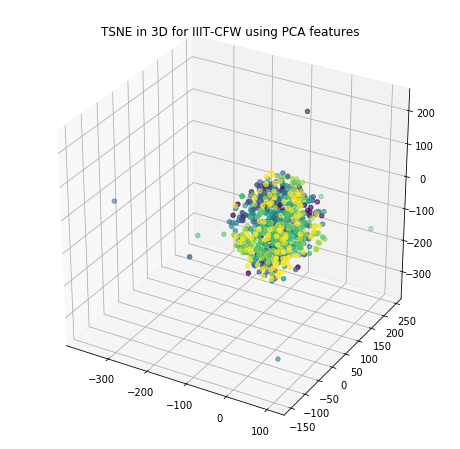

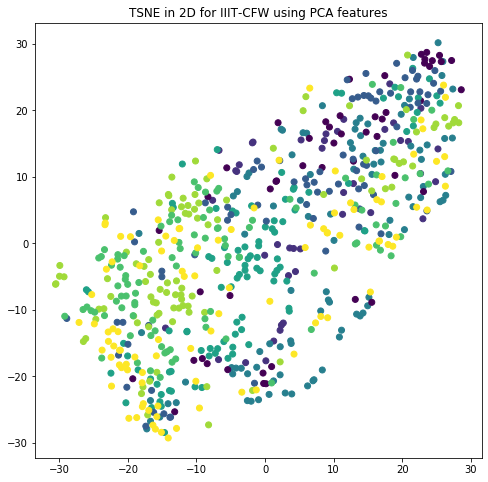

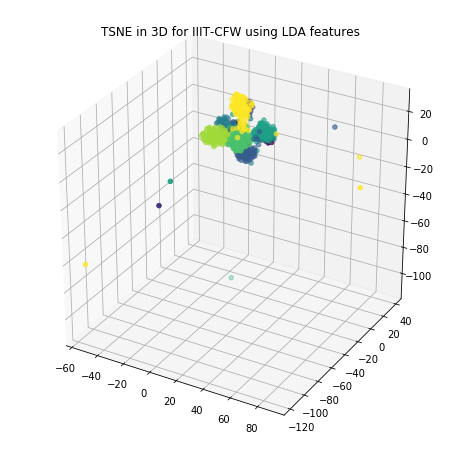

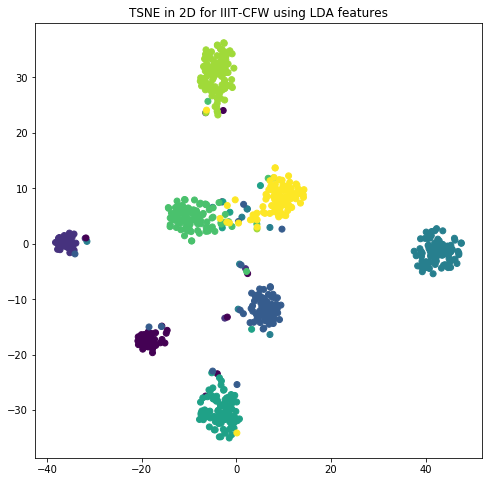

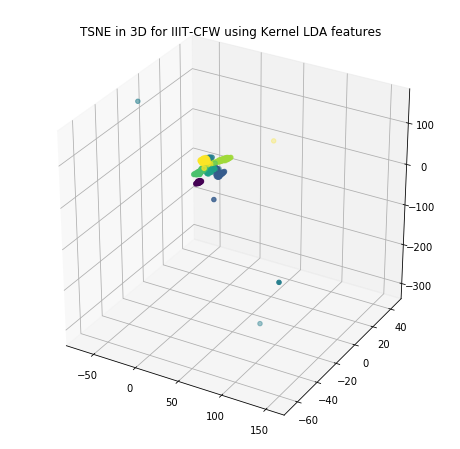

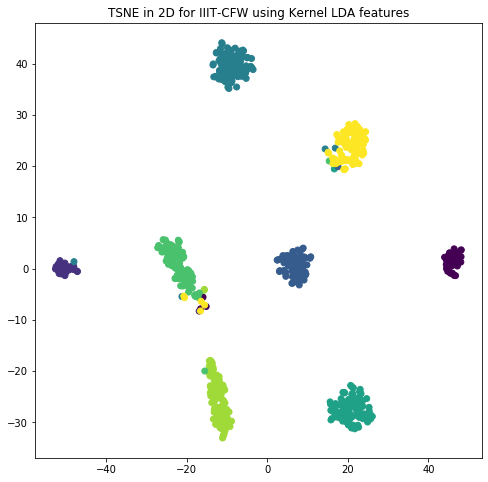

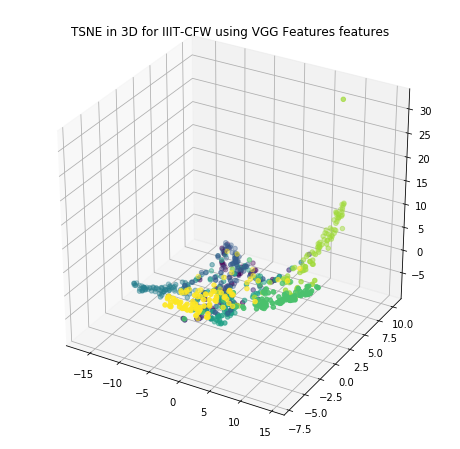

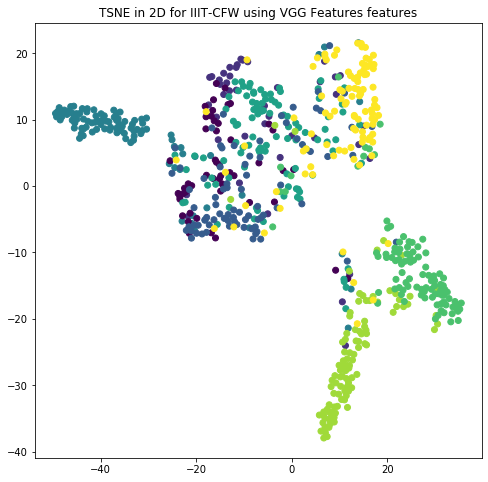

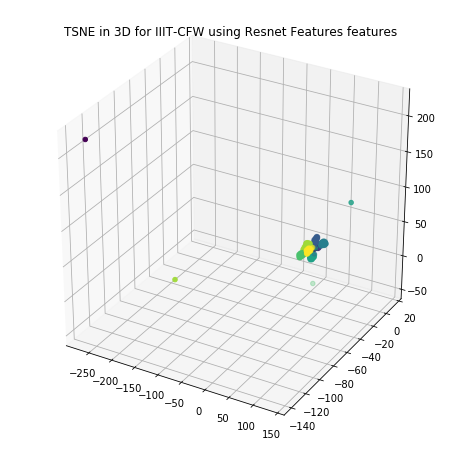

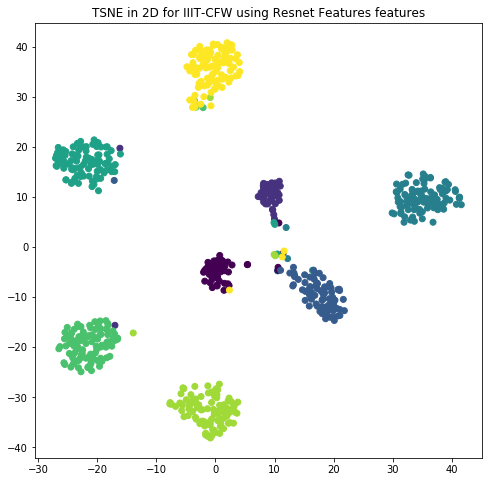

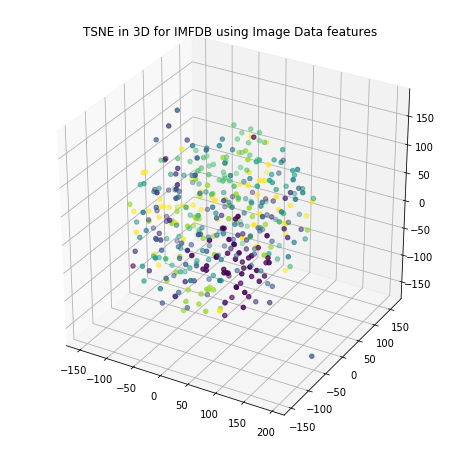

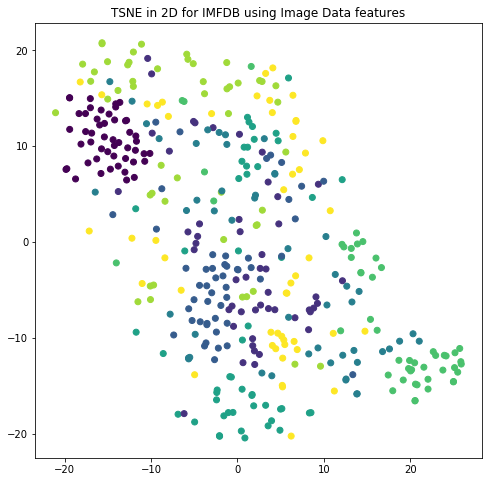

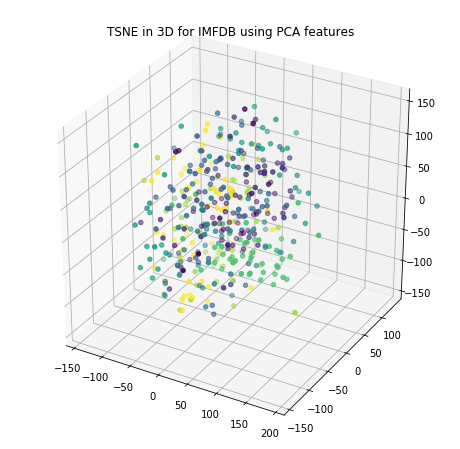

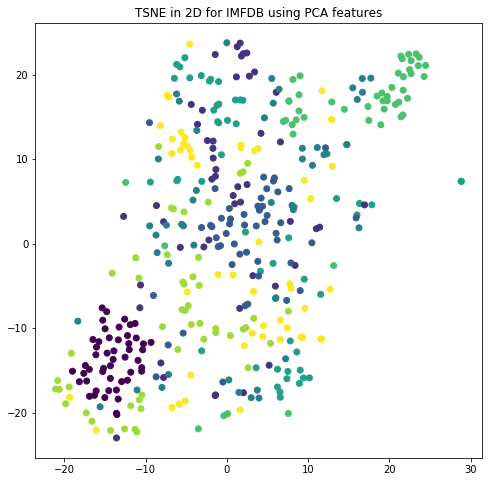

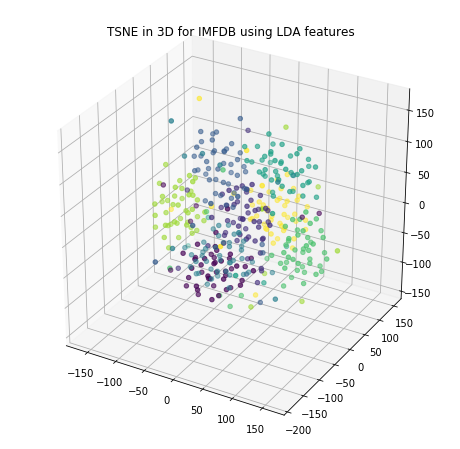

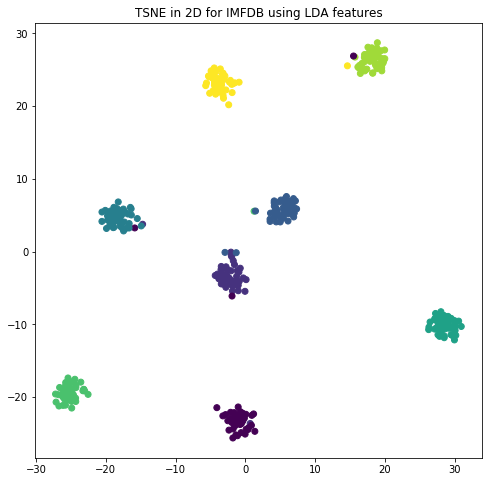

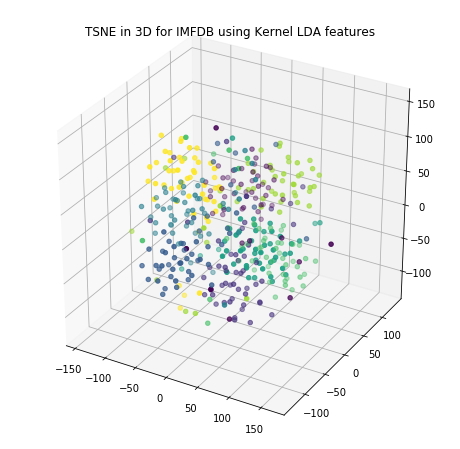

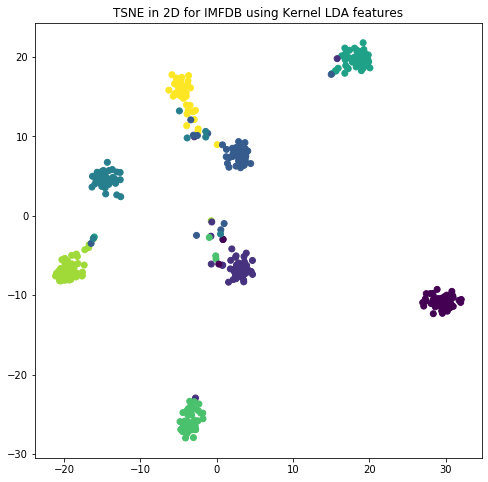

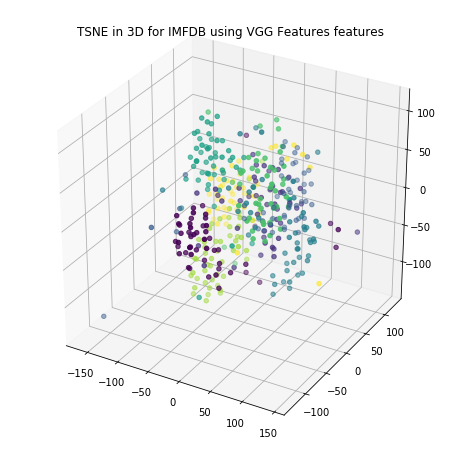

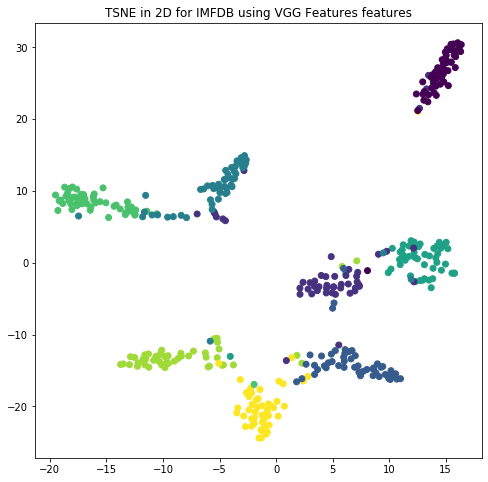

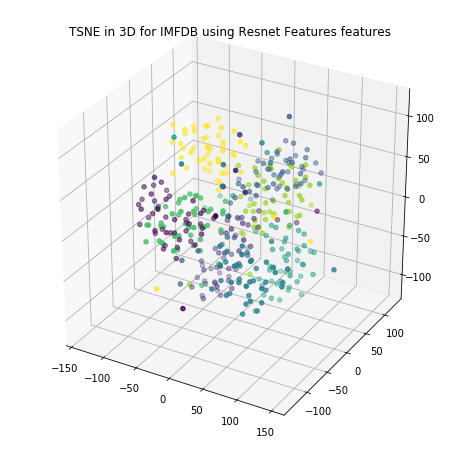

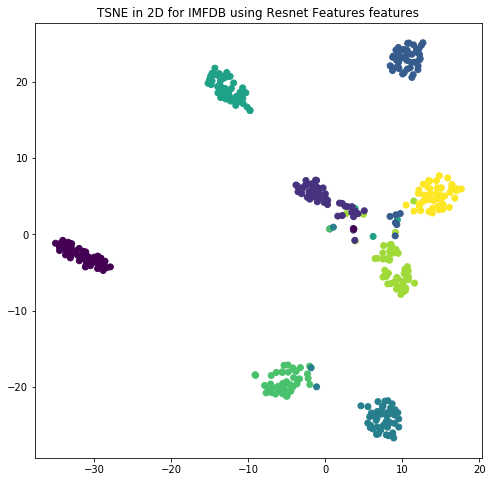

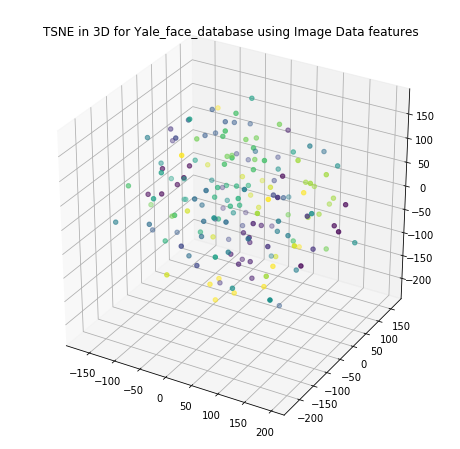

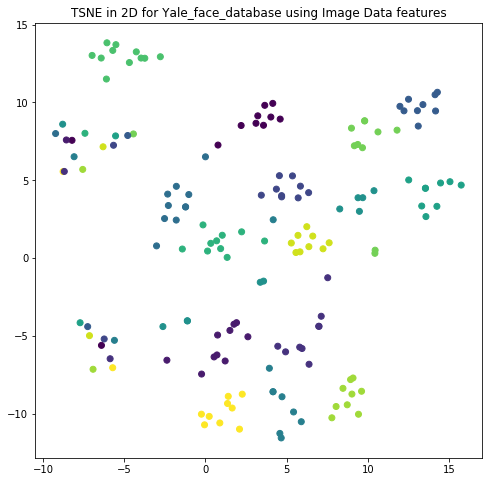

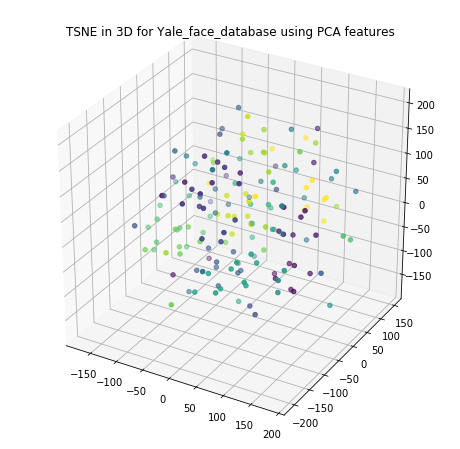

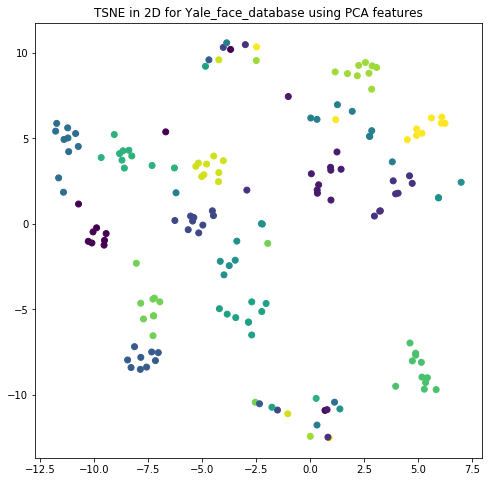

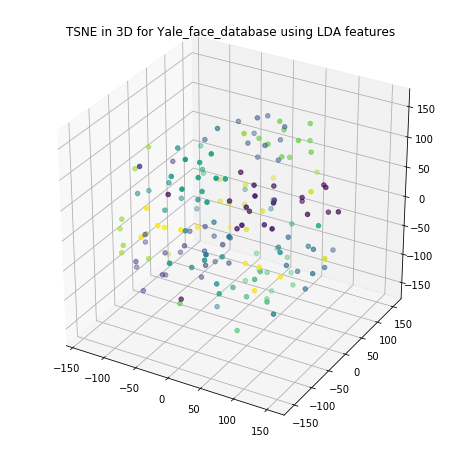

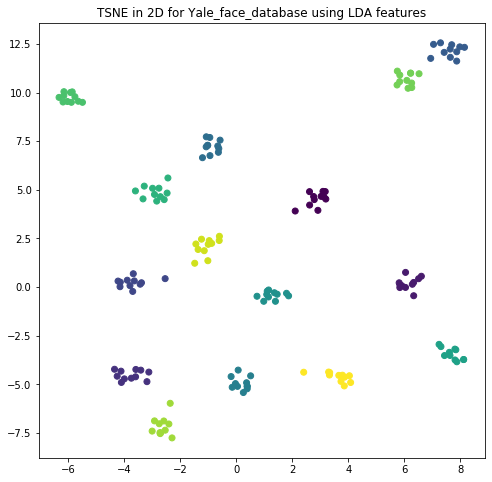

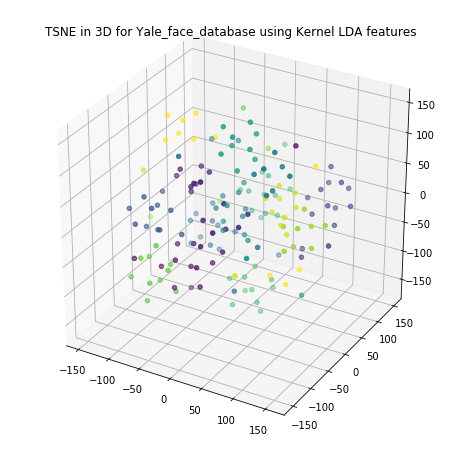

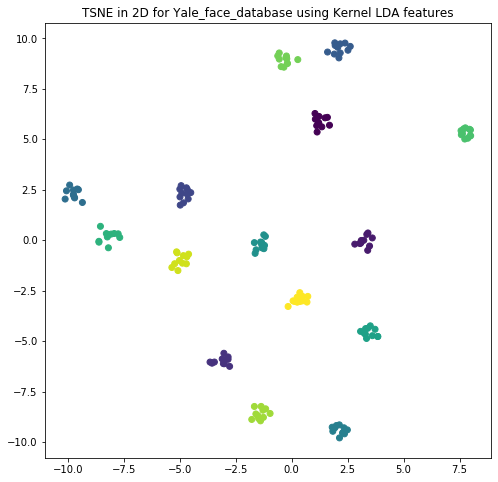

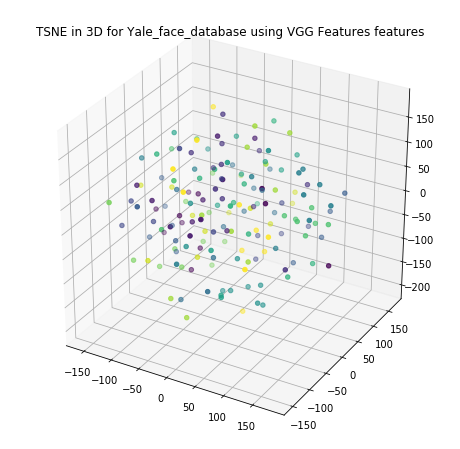

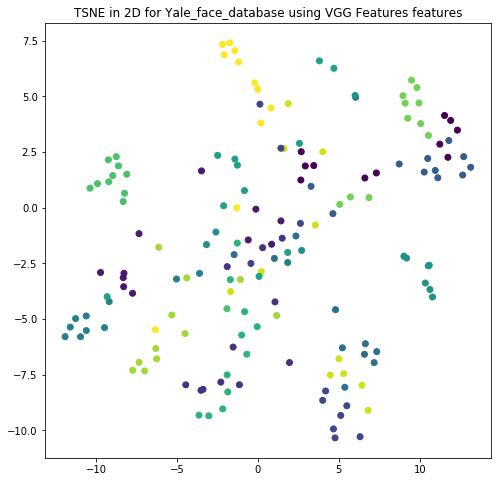

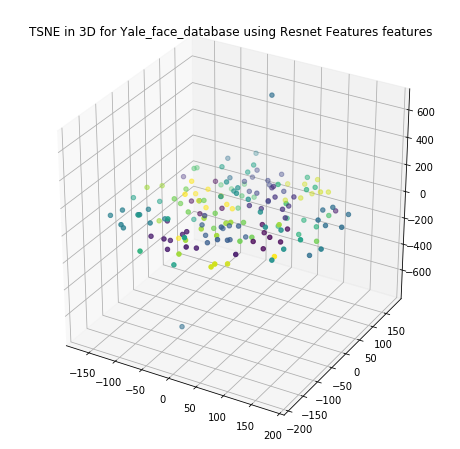

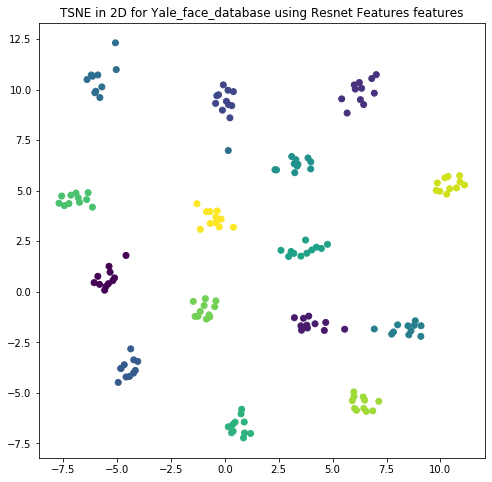

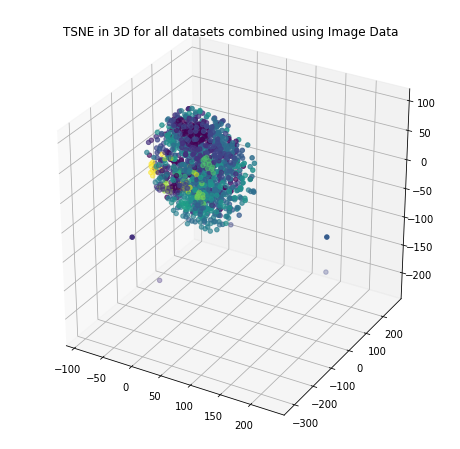

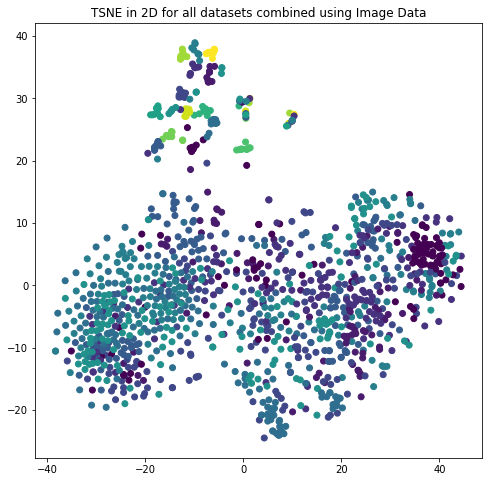

In [ ]:
# # Compute TSNE for different features and create a scatter plot
def TSNE_plot(X_feature, method):
    X_TSNE = TSNE(n_components=3).fit_transform(X_feature)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y_all[i])
    plt.title('TSNE in 3D for ' + dirpaths[i] + ' using ' + method + ' features')
    plt.show()
    X_TSNE = TSNE(n_components=2).fit_transform(X_feature)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y_all[i])
    plt.title('TSNE in 2D for ' + dirpaths[i] + ' using ' + method + ' features')
    plt.show()
for i in range(3):
    TSNE_plot(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 'Image Data')
    TSNE_plot(get_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), 'PCA')
    TSNE_plot(get_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), 'LDA')
    TSNE_plot(get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), 'Kernel LDA')
    TSNE_plot(get_vgg_features('./dataset/'+ dirpaths[i] + '/'), 'VGG Features')
    TSNE_plot(get_resnet_features('./dataset/'+ dirpaths[i] + '/'), 'Resnet Features')
X_feature = np.vstack((X_all[0].reshape((N_all[0],H_all[0]*W_all[0]*C_all[0])), X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])), X_all[2].reshape((N_all[2],H_all[2]*W_all[2]*C_all[2]))))
X_TSNE = TSNE(n_components=3).fit_transform(X_feature)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=np.vstack((np.expand_dims(y_all[0], axis=1),np.expand_dims(y_all[1], axis=1),np.expand_dims(y_all[2], axis=1))).squeeze())
plt.title('TSNE in 3D for ' + 'all datasets combined' + ' using Image Data')
plt.show()
X_TSNE = TSNE(n_components=2).fit_transform(X_feature)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=np.vstack((np.expand_dims(y_all[0], axis=1),np.expand_dims(y_all[1], axis=1),np.expand_dims(y_all[2], axis=1))).squeeze())
plt.title('TSNE in 2D for ' + 'all datasets combined' + ' using Image Data')
plt.show()

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

We could use k-Nearest Neighbour Algorithm to find out which class the given 'face' belongs to and check if the predicted class matches with the identity class. Output `yes` if it is a match and `no` otherwise

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

Since we want to use it for verification, the most important metric to optimize would be Precision since we don't want the system to yield false positives / a sample being able to pass verification when it shouldn't have.
_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [ ]:
class FaceVerification():
    def __init__(self, k):
        self.clf = KNeighborsClassifier(n_neighbors=3)
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        prediction = self.clf.predict(X)
        verification_results = prediction == class_id
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
    
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_predict = self.clf.predict(X_validate)
        correct = np.sum(y_predict == y_validate)
        accuracy = correct / y_validate.shape[0]
        error = 1 - accuracy
        precision = precision_score(y_validate, y_predict, average='macro')
        return error, accuracy, precision

In [ ]:
# Create a train and validation split and show your results 

In [ ]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
def score(x, X_train, X_validate, y_train, y_validate):
    clf = FaceVerification(x)
    clf.train(X_train, y_train)
    return clf.validate(X_validate, y_validate)
dirpaths = ['IIIT-CFW', 'IMFDB', 'Yale_face_database']
d = []
for i in range(3):
    d.append({'Method': [], 'Accuracy': [], 'Precision': [], 'Error': []})
    for x in [1, 3, 5]:
        X_train, X_validate, y_train, y_validate = train_test_split(get_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('PCA with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(get_kernel_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Kernel PCA with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(get_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('LDA with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Kernel LDA with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(get_vgg_features('./dataset/'+ dirpaths[i] + '/'), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('VGG Features with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(get_resnet_features('./dataset/'+ dirpaths[i] + '/'), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Resnet Features with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(np.hstack((get_resnet_features('./dataset/'+ dirpaths[i] + '/'), get_vgg_features('./dataset/'+ dirpaths[i] + '/'))), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('Resnet + VGG Features with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(np.hstack((get_kernel_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20))), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('KPCA + KLDA with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
        X_train, X_validate, y_train, y_validate = train_test_split(np.hstack((get_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), get_kernel_pca(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])), 20), get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), get_kernel_lda(X_all[i].reshape((N_all[i],H_all[i]*W_all[i]*C_all[i])),y_all[i],20), get_resnet_features('./dataset/'+ dirpaths[i] + '/'), get_vgg_features('./dataset/'+ dirpaths[i] + '/'))), y_all[i], test_size=0.25, random_state=42)
        error, accuracy, precision = score(x, X_train, X_validate, y_train, y_validate)
        d[i]['Method'].append('All Features with k=' + str(x))
        d[i]['Error'].append(error)
        d[i]['Accuracy'].append(accuracy)
        d[i]['Precision'].append(precision)
    print(dirpaths[i])
    df = pd.DataFrame(d[i])
    print(df)
# Print the table. (You can use Pandas)

IIIT-CFW
                            Method  Accuracy  Precision     Error
0                     PCA with k=1  0.488095   0.510889  0.511905
1              Kernel PCA with k=1  0.494048   0.529458  0.505952
2                     LDA with k=1  0.910714   0.905857  0.089286
3              Kernel LDA with k=1  0.964286   0.970833  0.035714
4            VGG Features with k=1  0.666667   0.639955  0.333333
5         Resnet Features with k=1  0.970238   0.967671  0.029762
6   Resnet + VGG Features with k=1  0.982143   0.983197  0.017857
7             KPCA + KLDA with k=1  0.964286   0.970833  0.035714
8            All Features with k=1  0.988095   0.992424  0.011905
9                     PCA with k=3  0.488095   0.510321  0.511905
10             Kernel PCA with k=3  0.494048   0.529458  0.505952
11                    LDA with k=3  0.910714   0.905857  0.089286
12             Kernel LDA with k=3  0.964286   0.970833  0.035714
13           VGG Features with k=3  0.666667   0.639955  0.333333
1

### Extension / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [ ]:
# Load data
x = pd.read_csv("./dataset/IMFDB/emotion.txt", header=None).values
print(x)
idx = x[:,0].argsort()
emotions = x[idx,1]
encode = {
    'DISGUST': 0,
    'HAPPINESS': 1,
    'SURPRISE': 2,
    'NEUTRAL': 3,
    'ANGER': 4,
    'SADNESS': 5,
    'FEAR': 6
}
decode = [
    'DISGUST',
    'HAPPINESS',
    'SURPRISE',
    'NEUTRAL',
    'ANGER',
    'SADNESS',
    'FEAR'
]
y = []
for i in emotions:
    y.append(encode[i])

[['Amir_0.png' 'DISGUST']
 ['Amir_1.png' 'DISGUST']
 ['Amir_2.png' 'DISGUST']
 ['Amir_3.png' 'DISGUST']
 ['Amir_4.png' 'DISGUST']
 ['Amir_5.png' 'DISGUST']
 ['Amir_6.png' 'HAPPINESS']
 ['Amir_7.png' 'HAPPINESS']
 ['Amir_8.png' 'SURPRISE']
 ['Amir_9.png' 'HAPPINESS']
 ['Amir_10.png' 'HAPPINESS']
 ['Amir_11.png' 'HAPPINESS']
 ['Amir_12.png' 'HAPPINESS']
 ['Amir_13.png' 'DISGUST']
 ['Amir_14.png' 'DISGUST']
 ['Amir_15.png' 'DISGUST']
 ['Amir_16.png' 'HAPPINESS']
 ['Amir_17.png' 'DISGUST']
 ['Amir_18.png' 'DISGUST']
 ['Amir_19.png' 'DISGUST']
 ['Amir_20.png' 'DISGUST']
 ['Amir_21.png' 'DISGUST']
 ['Amir_22.png' 'DISGUST']
 ['Amir_23.png' 'DISGUST']
 ['Amir_24.png' 'DISGUST']
 ['Amir_25.png' 'DISGUST']
 ['Amir_26.png' 'DISGUST']
 ['Amir_27.png' 'ANGER']
 ['Amir_28.png' 'DISGUST']
 ['Amir_29.png' 'HAPPINESS']
 ['Amir_30.png' 'NEUTRAL']
 ['Amir_31.png' 'DISGUST']
 ['Amir_32.png' 'DISGUST']
 ['Amir_33.png' 'DISGUST']
 ['Amir_34.png' 'DISGUST']
 ['Amir_35.png' 'HAPPINESS']
 ['Amir_36.png' 'HAPP

In [ ]:
print(X_all[1].shape, len(y))

(400, 64, 64, 3) 400


In [ ]:
# Define your features
X_f = get_kernel_lda(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])),y,50)

Accuracy = 0.93
Precision = 0.9491228070175439
Recall = 0.8809523809523809
F1 Score = 0.8966666666666668


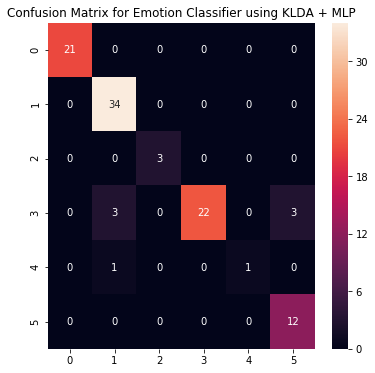

In [ ]:
# Create your classifier
clf = Classifier('MLP')
# Validate your classifier
X_train, X_validate, y_train, y_validate = train_test_split(pd.DataFrame(X_f), pd.Series(y), test_size=0.25, random_state=42)
clf.train(X_train, y_train)
confusion_mtx, accuracy, precision, recall, f1 = clf.validate(X_validate, y_validate)
print('Accuracy = ' + str(accuracy))
print('Precision = ' + str(precision))
print('Recall = ' + str(recall))
print('F1 Score = ' + str(f1))
plt.figure(figsize = confusion_mtx.shape)
ax = sn.heatmap(confusion_mtx, annot=True)
ax.set_ylim(confusion_mtx.shape[0], 0)
plt.title('Confusion Matrix for ' + 'Emotion Classifier' + ' using ' + 'KLDA + MLP')
plt.show()

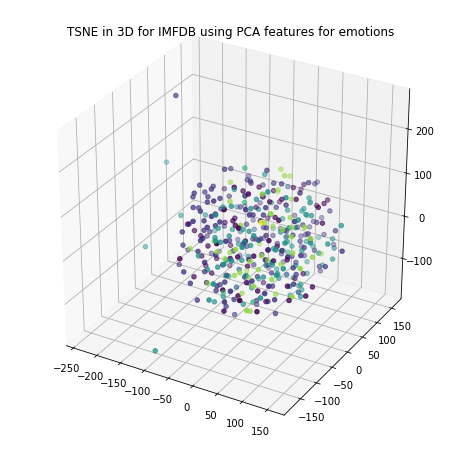

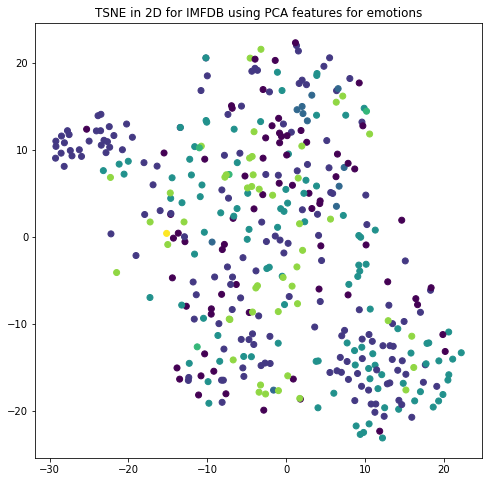

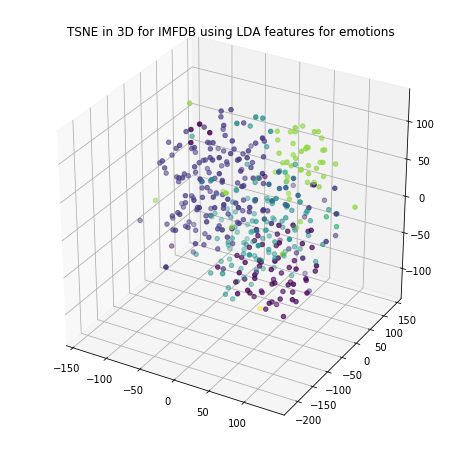

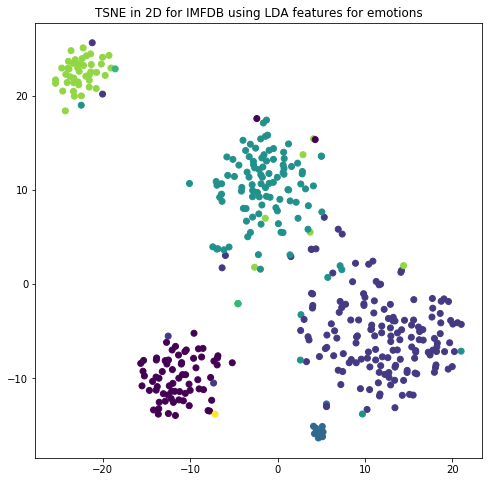

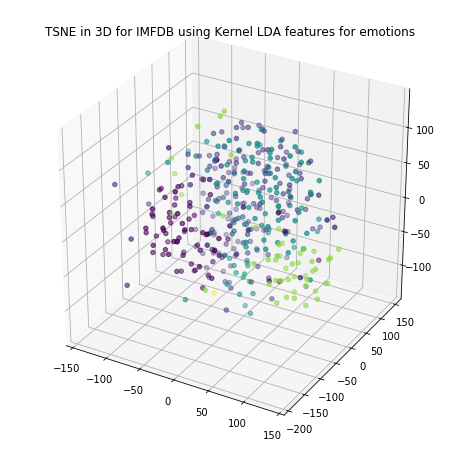

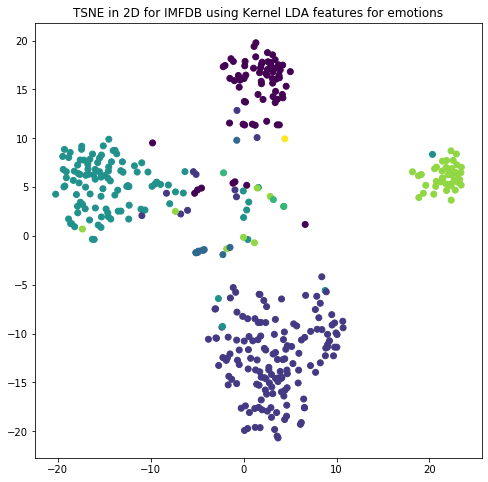

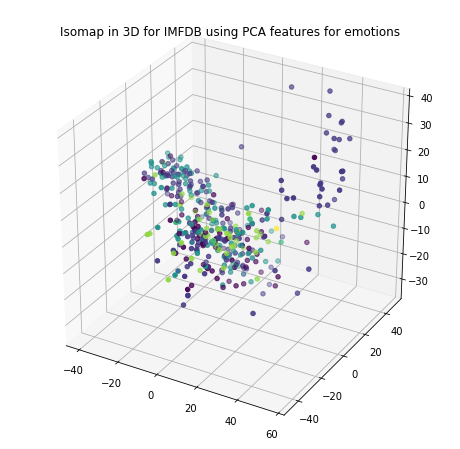

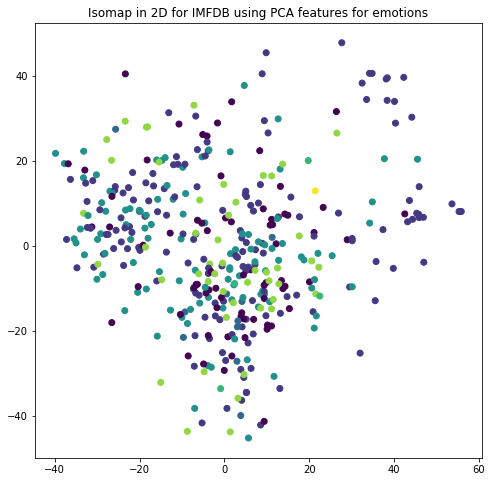

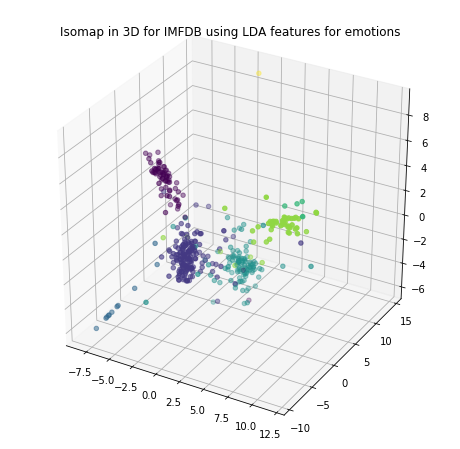

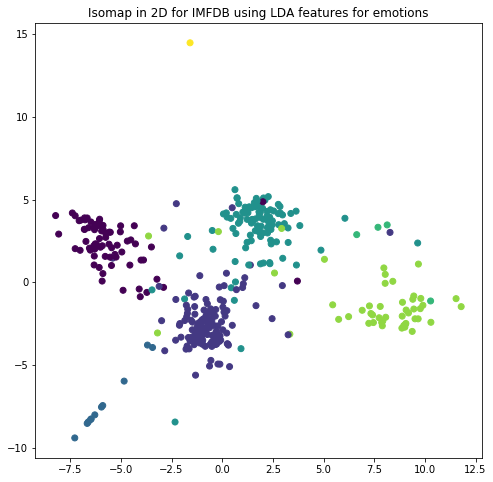

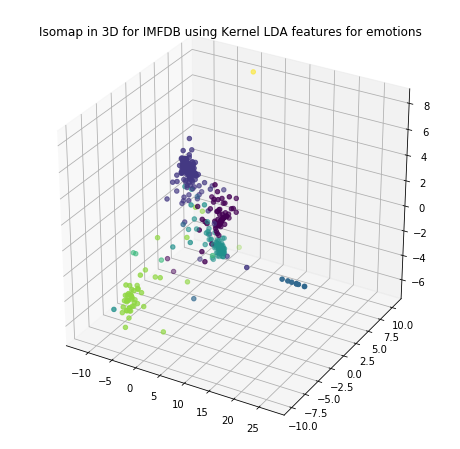

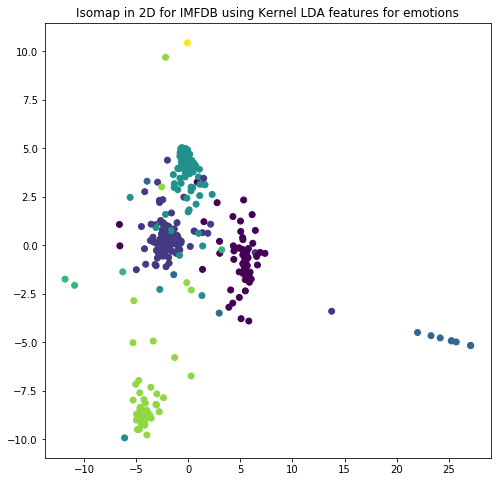

In [ ]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc. 
i = 1
def TSNE_plot(X_feature, method, y):
    X_TSNE = TSNE(n_components=3).fit_transform(X_feature)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
    plt.title('TSNE in 3D for ' + dirpaths[i] + ' using ' + method + ' features for emotions')
    plt.show()
    X_TSNE = TSNE(n_components=2).fit_transform(X_feature)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y)
    plt.title('TSNE in 2D for ' + dirpaths[i] + ' using ' + method + ' features for emotions')
    plt.show()
def Isomap_plot(X_feature, method, y):
    X_TSNE = Isomap(n_components=3).fit_transform(X_feature)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
    plt.title('Isomap in 3D for ' + dirpaths[i] + ' using ' + method + ' features for emotions')
    plt.show()
    X_TSNE = Isomap(n_components=2).fit_transform(X_feature)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y)
    plt.title('Isomap in 2D for ' + dirpaths[i] + ' using ' + method + ' features for emotions')
    plt.show()
TSNE_plot(get_pca(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])), 20), 'PCA', y)
TSNE_plot(get_lda(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])),y,20), 'LDA', y)
TSNE_plot(get_kernel_lda(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])),y,20), 'Kernel LDA', y)
Isomap_plot(get_pca(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])), 20), 'PCA', y)
Isomap_plot(get_lda(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])),y,20), 'LDA', y)
Isomap_plot(get_kernel_lda(X_all[1].reshape((N_all[1],H_all[1]*W_all[1]*C_all[1])),y,20), 'Kernel LDA', y)

In [ ]:
# K fold Validation
kf = KFold(n_splits=8, shuffle=True)
kf.get_n_splits(X_f)
a = []
for train_index, test_index in kf.split(X_f):
    X_train, X_test = X_f[train_index], X_f[test_index]
    y_train, y_test = np.asarray(y)[train_index], np.asarray(y)[test_index]
    clf = Classifier('MLP')
    clf.train(X_train, y_train)
    confusion_mtx, accuracy, precision, recall, f1 = clf.validate(X_test, y_test)
    a.append(accuracy)
print('Mean  Accuracy from 8-fold validation =', np.mean(a))

Mean  Accuracy from 8-fold validation = 0.915


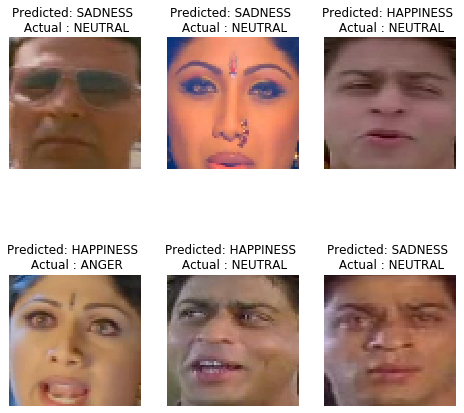

In [ ]:
# Show quantitative results such as examples of correct prediction and wrong prediction
clf = Classifier('MLP')
X_train, X_validate, y_train, y_validate = train_test_split(pd.DataFrame(X_f), pd.Series(y), test_size=0.25, random_state=42)
clf.train(X_train, y_train)
y_pred = clf.classify(X_validate)
misclassified_samples = np.flatnonzero(y_validate != y_pred)
miss_idx = []
pred_value = []
for i in range(6):
    miss_idx.append(X_validate.iloc[misclassified_samples[i]].name)
    pred_value.append(decode[y_pred[misclassified_samples[i]]])
imgs=X_all[1][miss_idx]
col=3
row=2
fig=plt.figure(figsize=(8, 8))
for i in range(1, col*row +1):
    img = imgs[i-1]
    fig.add_subplot(row, col, i)
    plt.imshow(img)
    plt.title("Predicted: {} \n Actual : {}".format(pred_value[i-1], decode[y[miss_idx[i-1]]]))
    plt.axis('off')
plt.show()

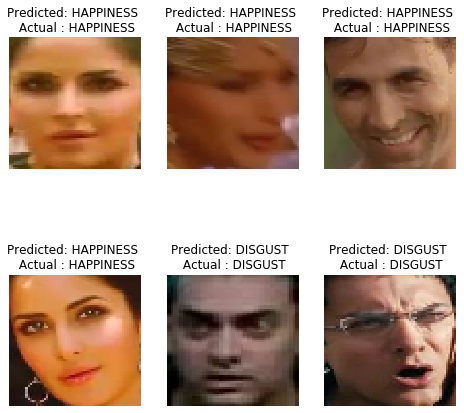

In [ ]:
y_pred = clf.classify(X_validate)
misclassified_samples = np.flatnonzero(y_validate == y_pred)
miss_idx = []
pred_value = []
for i in range(6):
    miss_idx.append(X_validate.iloc[misclassified_samples[i]].name)
    pred_value.append(decode[y_pred[misclassified_samples[i]]])
imgs=X_all[1][miss_idx]
col=3
row=2
fig=plt.figure(figsize=(8, 8))
for i in range(1, col*row +1):
    img = imgs[i-1]
    fig.add_subplot(row, col, i)
    plt.imshow(img)
    plt.title("Predicted: {} \n Actual : {}".format(pred_value[i-1], decode[y[miss_idx[i-1]]]))
    plt.axis('off')
plt.show()